In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-20 04:04:53.008858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 04:04:53.008883: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df = pd.read_csv('colheitas_abo.csv', parse_dates=['date'])
df = df.set_index('date')
df = df.groupby('abo').resample('M').sum()

In [4]:
df

nr
abo date            
A   1999-01-31  2471
    1999-02-28  2459
    1999-03-31  3581
    1999-04-30  2825
    1999-05-31  4777
...              ...
O   2019-08-31  6803
    2019-09-30  7464
    2019-10-31  8210
    2019-11-30  7773
    2019-12-31  7621

[1008 rows x 1 columns]

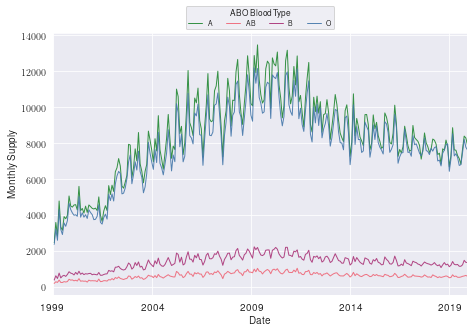

In [5]:
df.pivot_table(values="nr",index="date",columns="abo").plot(figsize=(17*cm,12*cm), linewidth=1, alpha=0.9, color=[colors[2], colors[1], colors[5], colors[0]], xlabel='Date', ylabel='Monthly Supply')
plt.legend(['A', 'AB', 'B', 'O'], title_fontsize='small', fontsize='x-small', title='ABO Blood Type', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
plt.tight_layout()
plt.savefig('figures/supply_monthly_abo.pdf', bbox_inches = "tight")

### Create batches of training data (12 months)

In [6]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [7]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=70, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mae')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [8]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    #print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)      
    
    print(actual)
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [9]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [10]:
def measure_error(actual, pred, step_in, step_out, index):
    print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [11]:
df1 = df.pivot_table('nr', 'date', 'abo')
df1['Total'] = df1.sum(axis=1)

In [12]:
dataset = df1[['A', 'AB', 'B', 'O']].values
dataset = df1[['A', 'AB', 'B', 'O']].astype('float32')
dataset_total = df1[['Total']].values
dataset_total = df1[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae, rmse, smape = train_predict(dataset[:216], dataset_total[:216], dataset[216:], df1[['Total']][216:].values)

2022-10-06 02:18:04.291474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-06 02:18:04.291524: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-06 02:18:04.291561: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-06 02:18:04.292036: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
7/7 [==============================] - 2s 12ms/step - loss: 0.5502
Epoch 2/500
7/7 [==============================] - 0s 12ms/step - loss: 0.4495
Epoch 3/500
7/7 [==============================] - 0s 11ms/step - loss: 0.3037
Epoch 4/500
7/7 [==============================] - 0s 12ms/step - loss: 0.1574
Epoch 5/500
7/7 [==============================] - 0s 12ms/step - loss: 0.1087
Epoch 6/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0995
Epoch 7/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0985
Epoch 8/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0939
Epoch 9/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0907
Epoch 10/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0908
Epoch 11/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0890
Epoch 12/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0886
Epoch 13/500
7/7 [==============================]

7/7 [==============================] - 0s 17ms/step - loss: 0.0634
Epoch 205/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0629
Epoch 206/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0641
Epoch 207/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0621
Epoch 208/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0618
Epoch 209/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0622
Epoch 210/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0632
Epoch 211/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0645
Epoch 212/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0663
Epoch 213/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0615
Epoch 214/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0611
Epoch 215/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0631
Epoch 216/500
7/7 [=======================

7/7 [==============================] - 0s 17ms/step - loss: 0.0589
Epoch 407/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0582
Epoch 408/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0581
Epoch 409/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0586
Epoch 410/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0576
Epoch 411/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0584
Epoch 412/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0589
Epoch 413/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0581
Epoch 414/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0581
Epoch 415/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0606
Epoch 416/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0613
Epoch 417/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0614
Epoch 418/500
7/7 [=======================

[[17547]
 [16046]] [[17452.723]
 [16521.213]] 16 18
[[16281]
 [15152]] [[16448.057]
 [16410.967]] 18 20
[[16891]
 [17140]] [[17352.  ]
 [17225.72]] 20 22
[[17906]
 [17587]] [[17277.986]
 [16386.623]] 22 24
[[14735]
 [16147]] [[16401.016]
 [15787.194]] 24 26
[[19452]
 [16729]] [[16868.54 ]
 [16747.969]] 26 28
[[16836]
 [16286]] [[17524.875]
 [16501.54 ]] 28 30
[[15569]
 [15315]] [[16715.643]
 [16594.662]] 30 32
[[16932]
 [18675]] [[17539.469]
 [17247.664]] 32 34
[[18050]
 [17451]] [[17728.44 ]
 [16413.885]] 34 36


### Calculate Error

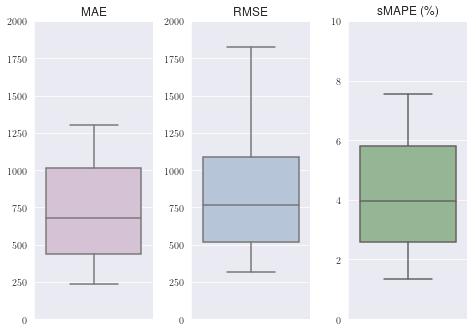

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 2000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 2000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
plt.savefig('figures/supply_lstm_monthly_abo_boxplot.pdf')

In [18]:
supply_lstm_month_abo = [mae,rmse,smape]
%store supply_lstm_month_abo 

Stored 'supply_lstm_month_abo' (list)
